In [167]:
# TODO:
# refactor model names (model, model_dom, model_dom_biased) to more appropiate names
# -> the new models are just pointers to the same model

# Elaborate on theoretical background of asymmetric gradient & input standardization
# Eventually expand discussion part with further points

# make sampling approach technically more smooth (take from Jascha?)
# -> DataLoader is cool but loades unnecessary data
# -> created a less cool but more efficient alternative

# manually plot roc curve with better thresholds
# -> changed to roc thresholds to show all but this won't change the plot

# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets, transforms
from torchsummary import summary

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import copy
import glob
import random

%matplotlib inline

In [169]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


# 1. The Dataset

## Load sample of healthy and diseased plants

In [ ]:
COLAB = True

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r"/content/drive/My Drive/data/"
    N_SAMPLES = 100
else:
    DATA_PATH = r"./images/"
    N_SAMPLES = 10

In [171]:
random.seed(7)
torch.manual_seed(7)

filelist = [
    *random.choices(glob.glob(DATA_PATH + "/Apple___healthy/*.JPG"), k=N_SAMPLES),
    *random.choices(glob.glob(DATA_PATH + "/Apple___Black_rot/*.JPG"), k=N_SAMPLES),
]

# load all images in filelist into tensor
X = torch.stack([transforms.ToTensor()(cv2.imread(fname)) for fname in filelist])
# X = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X) # normalize on vgg16 data
y = torch.tensor([0] * N_SAMPLES + [1] * N_SAMPLES)

In [ ]:
# plot some images in a grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

plot_images(X[y == 0], "Apple healthy")
plot_images(X[y == 1], "Apple black rot")

# TODO why are our diseases blue-ish? 

In [ ]:
# Visualise mean images

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
for cl, ax in zip(range(2), axs.flatten()):  #axs.flatten()
    label = torch.where(y == cl)
    ax.imshow(torch.mean(X[label].permute(0, 2, 3, 1), dim=0))  #, ax.axis('off')
    ax.set(xlabel=["Apple healthy", "Apple black rot"][cl], xticks=[], yticks=[])
plt.suptitle("Mean image for each class")
plt.tight_layout()

# 2. Pretrained Models for Image Recognition

In [173]:
model = nn.Sequential(
    *vgg16(weights=VGG16_Weights.DEFAULT).features,
    torch.nn.Flatten(start_dim=1)
)

# TODO since we chose the one without batch normalization, is the normalization done later still correct?

# TODO disable training for vgg16 base model?
# for param in model.parameters():
#     param.requires_grad = False

model.to(device) # model = pointer, for tensors: copy on other device
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# 3. Predicting Classes from Images

Split data into train and test, then run through model to get feature representation.

In [174]:
X = X.to(device)

# split data into train and test with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
with torch.no_grad():
    X_train_features = model(X_train).to("cpu")
    X_test_features = model(X_test).to("cpu")
    torch.cuda.empty_cache()

print(X_train_features.shape)

torch.Size([160, 32768])


Calculate mean feature representation per class to get ‘difference-of-means’ discriminant.

In [175]:
images_0_train = X_train_features[y_train == 0]
images_1_train = X_train_features[y_train == 1]
mean_0 = images_0_train.sum(dim=0) / images_0_train.size(0)
mean_1 = images_1_train.sum(dim=0) / images_1_train.size(0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()

print("Size of difference-of-means discriminant", w.size())
# print(w.get_device(), X_train.get_device())
# print(images_0_train.get_device())

# For Standardizing purposeses
X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)

torch.Size([32768])
-1 0
-1


Project data on the ‘difference-of-means’ discriminant using the dot product to score (new) instances.

In [176]:
pred_scores_train = torch.matmul(X_train_features, w)
pred_scores_test = torch.matmul(X_test_features, w)

Evaluate performance of ‘difference-of-means’ discriminant on test set

ROC AUC Score train:  0.99984375
ROC AUC Score test:  0.99


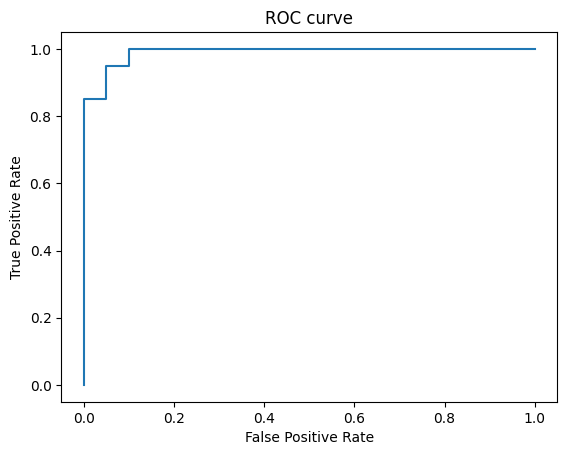

In [177]:
print("ROC AUC Score train:", roc_auc_score(y_train, pred_scores_train))
print("ROC AUC Score test:", roc_auc_score(y_test, pred_scores_test))

# plot a roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_scores_test, drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()


# 4. Understanding the Image-Class Relation Pixel-Wise

# 4.1 Sensitivity Analysis

Add linear layer representing the projection on the mean difference vector.

In [178]:
projection_layer = torch.nn.Linear(in_features=X_train_features.size()[1], out_features=1, bias=False)

# use w as the weights for the projection layer
projection_layer.weight = torch.nn.Parameter(w.to(device))

# add the projection layer to the model to get the different of means model
model_dom = model.append(projection_layer)

# TODO CHECK IF THIS WORKS, IF SO REMOVE BELOW
# # with torch.no_grad():
# model_dom[-1].weight = torch.nn.Parameter(w.to(device))
# print(model_dom[-1].weight)

Parameter containing:
tensor([1.0068e-03, 4.4715e-05, 4.7594e-04,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], device='cuda:0', requires_grad=True)


Pixle-wise explaination for a given image:
- look at derivative of model w.r.t. input pixel
- compute importance scores by computing square norm of gradient per pixel (over channels)
- render scores as heatmap

In [26]:
# TODO what does that mean in the PDF? 

# " Interestingly, this analysis would reduce to analyzing the difference of mean vectors when choosing the simple feature representation Φ(x) = x."

Apply Sensitivity Analysis on image:

In [ ]:
def get_sensitivity(model, input_data):
  output = model(input_data)
  #print(f"Predicted score: {output[0]:.2f}")
  output.backward()
  sensitivity = input_data.grad.norm(dim=1).to("cpu") # TODO square norm?
  return sensitivity


def plot_sensitivity_analysis(test_set_id=25, model=model_dom):

  img = X_test[test_set_id].unsqueeze(0) # on device

  input_data_standardized = (img - X_train_mean) / X_train_std

  # mean and std per channel from vgg16 training set
  input_data_standardized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)

  img.requires_grad = True
  input_data_standardized.requires_grad = True
  input_data_standardized_vgg16.requires_grad = True


  # get sensitivity
  sensitivity = get_sensitivity(model, img)
  sensitivity_norm = get_sensitivity(model, input_data_standardized)
  sensitivity_norm_vgg16 = get_sensitivity(model, input_data_standardized_vgg16)

  # plot to images
  fig, axs = plt.subplots(2, 3, figsize=(15, 12))

  axs[0, 0].imshow(torch.permute(img[0].detach().cpu(), (1, 2, 0)))
  axs[0, 1].imshow(torch.permute(input_data_standardized[0].detach().cpu(), (1, 2, 0)))
  axs[0, 2].imshow(torch.permute(input_data_standardized_vgg16[0].detach().cpu(), (1, 2, 0)))
  axs[1, 0].imshow(sensitivity.squeeze(0), cmap="Reds")
  axs[1, 1].imshow(sensitivity_norm.squeeze(0), cmap="Reds")
  axs[1, 2].imshow(sensitivity_norm_vgg16.squeeze(0), cmap="Reds")

  axs[0, 0].set_title('Unprocessed image')
  axs[0, 1].set_title('Standardized image on train data')
  axs[0, 2].set_title('Normalized image on vgg16 data')
  axs[1, 0].set_title('Importance scores (using input above)')
  axs[1, 1].set_title('Importance scores (using input above)')
  axs[1, 2].set_title('Importance scores (using input above)')

  fig.suptitle(f"Sensitivity Analysis for Prediction, label: {y_test[test_set_id]}")
  for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
  plt.tight_layout()

plot_sensitivity_analysis(test_set_id=25, model=model_dom)

# 4.2 More Robust Explanations

Bias convulution layers

In [180]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.clip(self.og_conv.weight, min=0)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.clip(self.og_conv.bias, min=0)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

In [181]:
# test biased layer with a tensor

# create Conv2d layer
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
biased_conv = BiasedLayer(conv)

# Create Artificial Input
test_input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity for both versions
conv_output = conv(test_input_data)
conv_output.backward()
conv_sensitivity = test_input_data.grad.norm(dim=1)

test_conv_output = conv(test_input_data)
test_conv_output.backward()
test_conv_sensitivity = test_input_data.grad.norm(dim=1)

# Compare
print(f"Test conv output: {conv_output},\nTransformed conv output: {test_conv_output[0]}")
print("\nTest conv Sensitivity:\n", conv_sensitivity)
print("Transformed conv output:\n", test_conv_sensitivity)

Test conv output: tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>),
Transformed conv output: tensor([[[10.]]], grad_fn=<SelectBackward0>)

Test conv Sensitivity:
 tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
Transformed conv output:
 tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])


Copy previouse model but replace Conv2d with our biased layer

In [182]:
# last linear layer is not considered by default
model_dom_biased = nn.Sequential(*[BiasedLayer(l) if isinstance(l, torch.nn.Conv2d) and i > 0 else l for i,l in enumerate(model_dom.children())])
model_dom_biased.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (biased_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (biased_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (biased_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (biased_conv): Conv2d(128, 256, kernel_size=(3,

In [ ]:
plot_sensitivity_analysis(test_set_id=25, model=model_dom_biased)

In [184]:
# compare different models
def plot_sensitivity_imgs(images):
    """ images - of shape [b, C, H, W] and stored on device """

    fig, axs = plt.subplots(len(images), 5, figsize=(20, 15))

    for i, img in enumerate(images):

        # Create standardized input
        img = img.detach() # make sure that input is leaf
        input_data_standardized = (img - X_train_mean) / X_train_std
        input_data_standardized = input_data_standardized.unsqueeze(0)
        input_data_standardized.requires_grad = True

        # create normalized input using vgg16 data
        input_data_normalized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img).unsqueeze(0)
        input_data_normalized_vgg16.requires_grad = True

        # Regular input
        input_data = img.unsqueeze(0)
        input_data.requires_grad = True

        # get sensitivity
        sensitivity_diff = get_sensitivity(model_dom, input_data)
        sensitivity_biased = get_sensitivity(model_dom_biased, input_data)
        sensitivity_biased_norm = get_sensitivity(model_dom_biased, input_data_standardized)
        sensitivitiy_biased_norm_vgg = get_sensitivity(model_dom_biased, input_data_normalized_vgg16)
        # prepare input_data for plotting
        input_data = input_data.detach().cpu().squeeze(0)

        if len(images) > 1:
          axs[i, 0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[i, 1].imshow(sensitivity_diff.squeeze(0), cmap="Reds")
          axs[i, 2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[i, 3].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[i, 4].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")
        else:
          axs[0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[1].imshow(sensitivity_diff.squeeze(0), cmap="Reds")
          axs[2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[3].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          axs[4].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")

        if (i == 0) & (len(images) > 1):
            axs[i, 0].set_title(f"Original Image")
            axs[i, 1].set_title(f"'Normal' Gradient")
            axs[i, 2].set_title(f"'Asymmetric' Gradient")
            axs[i, 3].set_title(f"'Asymmetric' Gradient (Standardized)")
            axs[i, 4].set_title(f"'Asymmetric' Gradient \n(Normalized on vgg16 data)")
        elif (i == 0):
            axs[0].set_title(f"Original Image")
            axs[1].set_title(f"'Normal' Gradient")
            axs[2].set_title(f"'Asymmetric' Gradient")
            axs[3].set_title(f"'Asymmetric' Gradient (Standardized)")
            axs[4].set_title(f"'Asymmetric' Gradient \n(Normalized on vgg16 data)")

        #fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_sensitivity_imgs(X_test[[0, 11, 14, 16, 17, 25]]) # images[0] ist gut # [0,14]

# Double check with results from pdf

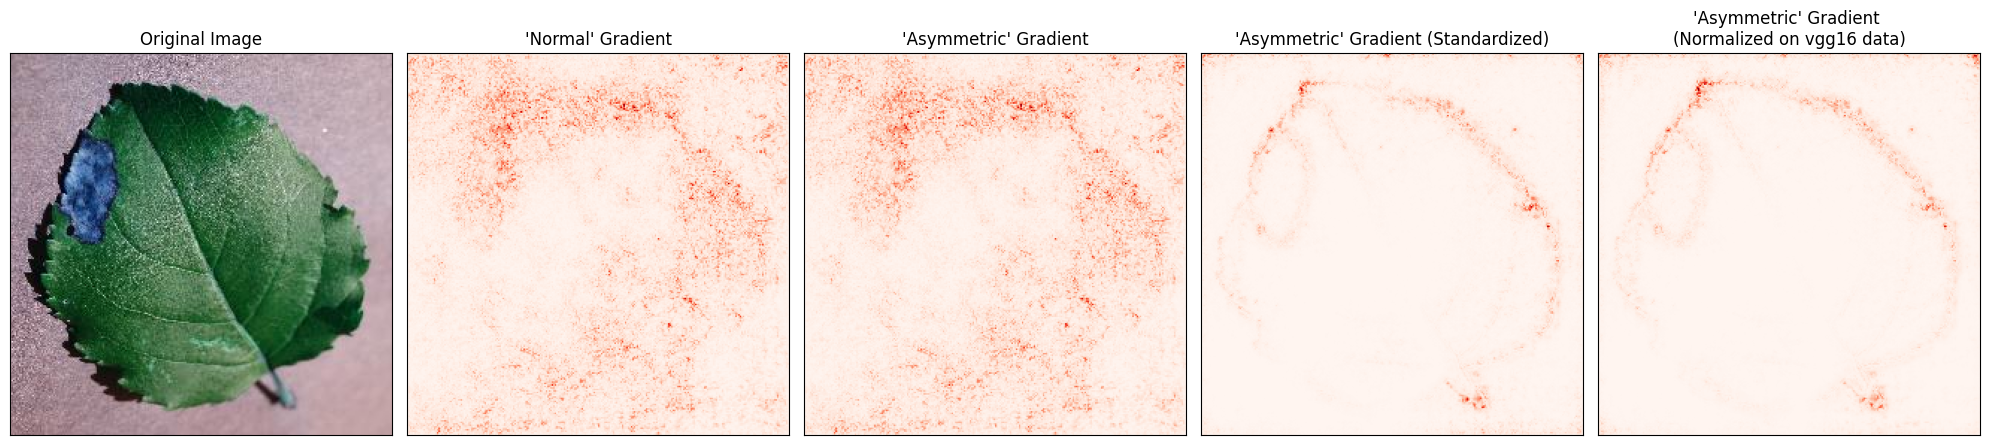

In [186]:
example_path = DATA_PATH + "/Apple___Black_rot/image (50).JPG"
example = transforms.ToTensor()(cv2.imread(example_path)).to(device)
example.requires_grad = True
plot_sensitivity_imgs(example.unsqueeze(0))

# 4.3 Discussion
Possible sources of mismatch:


## Insufficiently good pretrained neural network
- the pretext training is just not trained good enough to derive generalizable features; maybe not even for the pretext task itself
### Possible solutions:
- check model performance of pretrained model on upstream task
- try to fine-tune model on our task at hand
- check if there exist other downstream task are suitable to this approach (derive evidence that the approach might be valid)

## Improper method for extracting relevant features
- each layer of the pretext task probabely captures different aspects/features of the image
- taking the last layer may be an inacurate choice for the downstream task at hand, i.e. detecting the disease
- we can see that the contours are captured in our sensitivity analysis, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also sometimes detected)
- also, the data set might be too different from our dataset (i.e. focussing on cars, animals, etc. instead of leaves)
### Possible solutions:
- Try cutting of more layers to extract features
- Try to fine-tune on dataset at hand

## Problems with data quality
- resoultion is quite low --> model can't capture detailed structures/features are too vague
- shadows might disturbe features/introduce unwanted noise hardening the detection of structures related to the disease

### Possible solutions:
- increase resolution of images with designated machine learning models
- try to remove shadows either manually or with other machine learning models
- manually subsample images with less shadows included
- try to get images with higher resolution and/or without shadows in the picture to reduce noise

## Flawed understanding by the human of the plant disease
- disease might effect subtle areas of the plant which might be either hard to detect for a human or even unkown to humans due to its hard decetability
### Possible solutions:
- get in touch with people with domain knowledge
- double-check if there might be subtle structures changing due to the disease which might be unknown so far to the domain-experts